In [1]:

import random

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_svmlight_file

from gossip_generator import gossip_generator

params_for_plots = {'legend.fontsize': 'medium',
                    'figure.figsize': (30, 30),
                    'axes.labelsize': 'medium',
                    'axes.titlesize': 'medium',
                    'xtick.labelsize': 'medium',
                    'ytick.labelsize': 'medium'}
plt.rcParams.update(params_for_plots)

In [2]:
dataset = "mushrooms.txt"

data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = 2 * y - 3

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
def f(X, Y, w, mu):
    return 1 / X_train.shape[0] * np.linalg.norm(np.dot(X, w) - Y, 2) ** 2 + mu * np.linalg.norm(w, 2) ** 2


def gradient(X, Y, w, mu):
    return 2 / X_train.shape[0] * (np.dot(X.T, np.dot(X, w)) - np.dot(X.T, Y)) + 2 * mu * w

In [5]:
def gradient_descent(X, Y, w_0, alpha, epsilon, max_iter=1_000_0):
    w = w_0
    for i in range(max_iter):
        grad = gradient(X, Y, w, mu)
        w = w - alpha * grad
    return w

In [6]:
L = np.abs(np.max(np.linalg.eig(2 / X_train.shape[0] * np.dot(X_train.T, X_train))[0]))
batch_size = 10
device_num = 25
mu = L / 100
L += mu

print(L)

20.883882012008236


In [7]:
true_ans = gradient_descent(X_train, y_train, np.zeros(X_train.shape[1]), 1 / L, 1e-6)

In [27]:
true_ans

array([-3.13852180e-03,  3.56536574e-02, -2.52722516e-02, -5.42467134e-03,
        1.58181096e-02, -1.65748610e-02,  7.70227601e-03, -6.00185145e-02,
       -3.38502003e-03,  5.67627198e-02,  8.49595248e-03, -5.00375059e-02,
        5.21291028e-03,  4.37259489e-03,  3.29031420e-02, -3.86110552e-02,
        1.05251920e-02,  1.22696034e-02, -1.31750109e-02,  2.91056382e-02,
        7.61382452e-02, -7.50767839e-02,  1.03064539e-01, -9.48401806e-02,
       -2.21577155e-01, -1.88580913e-02,  9.86729046e-02,  3.63120136e-01,
       -1.17518614e-01, -5.63101907e-02, -5.46918869e-02,  2.64874894e-02,
       -2.54260281e-02, -1.18892803e-01,  1.19954264e-01,  2.13836949e-01,
       -2.12775488e-01, -1.10882487e-01,  1.98133521e-02, -1.54808059e-02,
       -3.31683415e-02,  2.52615846e-02,  1.22466444e-02,  6.05251123e-02,
        8.22169983e-04, -2.02425085e-02,  2.19232726e-02,  4.04083650e-02,
       -1.64896995e-04, -2.16033088e-02,  2.26647701e-02, -6.33401329e-04,
        9.87433073e-02, -

In [8]:
# W_0 = np.array([
#     [0.5, 0, 0.5, 0, 0, 0],
#     [0, 1 / 3, 1 / 3, 0, 1 / 3, 0],
#     [0, 0.25, 0.25, 0, 0.25, 0.25],
#     [0, 0, 0.5, 0.5, 0, 0],
#     [0, 0.5, 0, 0, 0.5, 0],
#     [0, 0, 0.5, 0, 0, 0.5]])

W_0 = gossip_generator(device_num)
print(W_0)

[[0.11111111 0.         0.11111111 0.         0.11111111 0.
  0.         0.         0.         0.         0.         0.11111111
  0.         0.         0.11111111 0.11111111 0.11111111 0.
  0.11111111 0.         0.         0.11111111 0.         0.
  0.        ]
 [0.         0.2        0.         0.         0.         0.
  0.2        0.         0.         0.         0.         0.2
  0.         0.         0.         0.         0.         0.
  0.2        0.         0.         0.         0.2        0.
  0.        ]
 [0.11111111 0.         0.11111111 0.         0.11111111 0.11111111
  0.         0.         0.11111111 0.         0.         0.11111111
  0.         0.11111111 0.         0.         0.         0.
  0.         0.         0.         0.11111111 0.11111111 0.
  0.        ]
 [0.         0.         0.         0.1        0.         0.
  0.1        0.1        0.         0.1        0.1        0.
  0.1        0.1        0.         0.         0.         0.
  0.         0.1        0.1      

In [10]:
def fast_mix(gradients, W=W_0, rounds=1000):
    Z = np.copy(gradients)
    Z_previous = np.copy(Z)
    lamb_2 = np.sort(np.linalg.eig(W)[0])[-2]
    eta = (1 - np.sqrt(1 - np.power(lamb_2, 2))) / (1 + np.sqrt(1 + np.power(lamb_2, 2)))
    for r in range(rounds):
        Z_next = (1 + eta) * np.dot(Z, W) - eta * Z_previous
        Z_previous = Z
        Z = Z_next

    return Z

In [11]:
L_waved = L * 4 / batch_size
sigma = mu / L_waved

theta1 = min(np.sqrt(2 * sigma * 2 * X_train.shape[0] / batch_size / 3), 1 / 2)
stepsize = 1 / 2 / (1 + 1 / 2) / theta1

eta_x_sigma = stepsize * sigma
eta_div_L_waved = stepsize / L_waved

In [12]:
print(eta_x_sigma, eta_div_L_waved, theta1)

0.0165016501650165 0.07980636290266019 0.5


In [14]:
def DVPL(X_train, y_train, max_iter, devices_num, w_0, eta_x_sigma, eta_div_L_waved, theta1, f, gradient, batch_size, L,
         mu, theta2=0.5, P=1000, p=1 / 10):
    proc = np.zeros(max_iter)
    x_axis = np.zeros(max_iter)
    y = np.copy(w_0)
    z = np.copy(w_0)
    w = np.copy(w_0)
    g = np.copy(w_0)
    z_new = np.copy(w_0)
    x_axis = np.zeros(max_iter)

    divide_by = abs(f(X_train, y_train, w_0, mu) - f(X_train, y_train, true_ans, mu))

    batches = np.zeros((batch_size, devices_num))
    gradf_w = gradient(X_train, y_train, w, mu)
    device_features = X_train.shape[1] // devices_num

    for i in range(max_iter):
        x = theta1 * z + 1 / 2 * w + (1 - theta1 - 1 / 2) * y
        proc[i] = abs(f(X_train, y_train, x, mu) - f(X_train, y_train, true_ans, mu)) / divide_by
        rows = np.random.choice(X_train.shape[0], batch_size, replace=False)
        for j in range(devices_num):
            X_on_device = []
            if j < devices_num - 1:
                X_on_device = X_train[rows, j * device_features: (j + 1) * device_features]
                batches[:, j] = np.dot(X_on_device, x[j * device_features: (j + 1) * device_features] - w[
                                                                                                        j * device_features: (
                                                                                                                                         j + 1) * device_features])
            else:
                X_on_device = X_train[rows, j * device_features:]
                batches[:, j] = np.dot(X_on_device, x[j * device_features:] - w[j * device_features:])

        batches = device_num * fast_mix(batches, W=W_0, rounds=P)

        for j in range(devices_num):
            if j < devices_num - 1:
                g = batches[:, j]
                g = 2 / batch_size * np.dot(X_train[rows, j * device_features: (j + 1) * device_features].T,
                                            g) + gradf_w[j * device_features: (j + 1) * device_features]
                z_new = (eta_x_sigma * x[j * device_features: (j + 1) * device_features] + z[j * device_features: (
                                                                                                                              j + 1) * device_features] - eta_div_L_waved * g) / (
                                    1 + eta_x_sigma)
                y[j * device_features: (j + 1) * device_features] = x[j * device_features: (
                                                                                                       j + 1) * device_features] + theta1 * (
                                                                                z_new - z[j * device_features: (
                                                                                                                           j + 1) * device_features])
                z[j * device_features: (j + 1) * device_features] = np.copy(z_new)
            else:
                g = batches[:, j]
                g = 2 / batch_size * np.dot(X_train[rows, j * device_features:].T, g) + gradf_w[j * device_features:]
                z_new = (eta_x_sigma * x[j * device_features:] + z[j * device_features:] - eta_div_L_waved * g) / (
                            1 + eta_x_sigma)
                y[j * device_features:] = x[j * device_features:] + theta1 * (z_new - z[j * device_features:])
                z[j * device_features:] = z_new

        if (random.random() < p):
            w = np.copy(y)
            gradf_w = gradient(X_train, y_train, w, mu)
            size_to_add_when_random_eq_p = P / devices_num
            x_axis[i] = size_to_add_when_random_eq_p if i == 0 else x_axis[i - 1] + size_to_add_when_random_eq_p
        else:
            size_to_add_when_random_neq_p = 1
            x_axis[i] = size_to_add_when_random_neq_p if i == 0 else x_axis[i - 1] + size_to_add_when_random_neq_p
        

    return proc, x_axis

Let's run DVPL on fixed parameters

/var/folders/_q/h4h3ghz564s22rz24b7hmy440000gn/T/ipykernel_2794/100685043.py:17: RuntimeWarning: divide by zero encountered in log
  plt.plot(x_axis, np.log(proc))


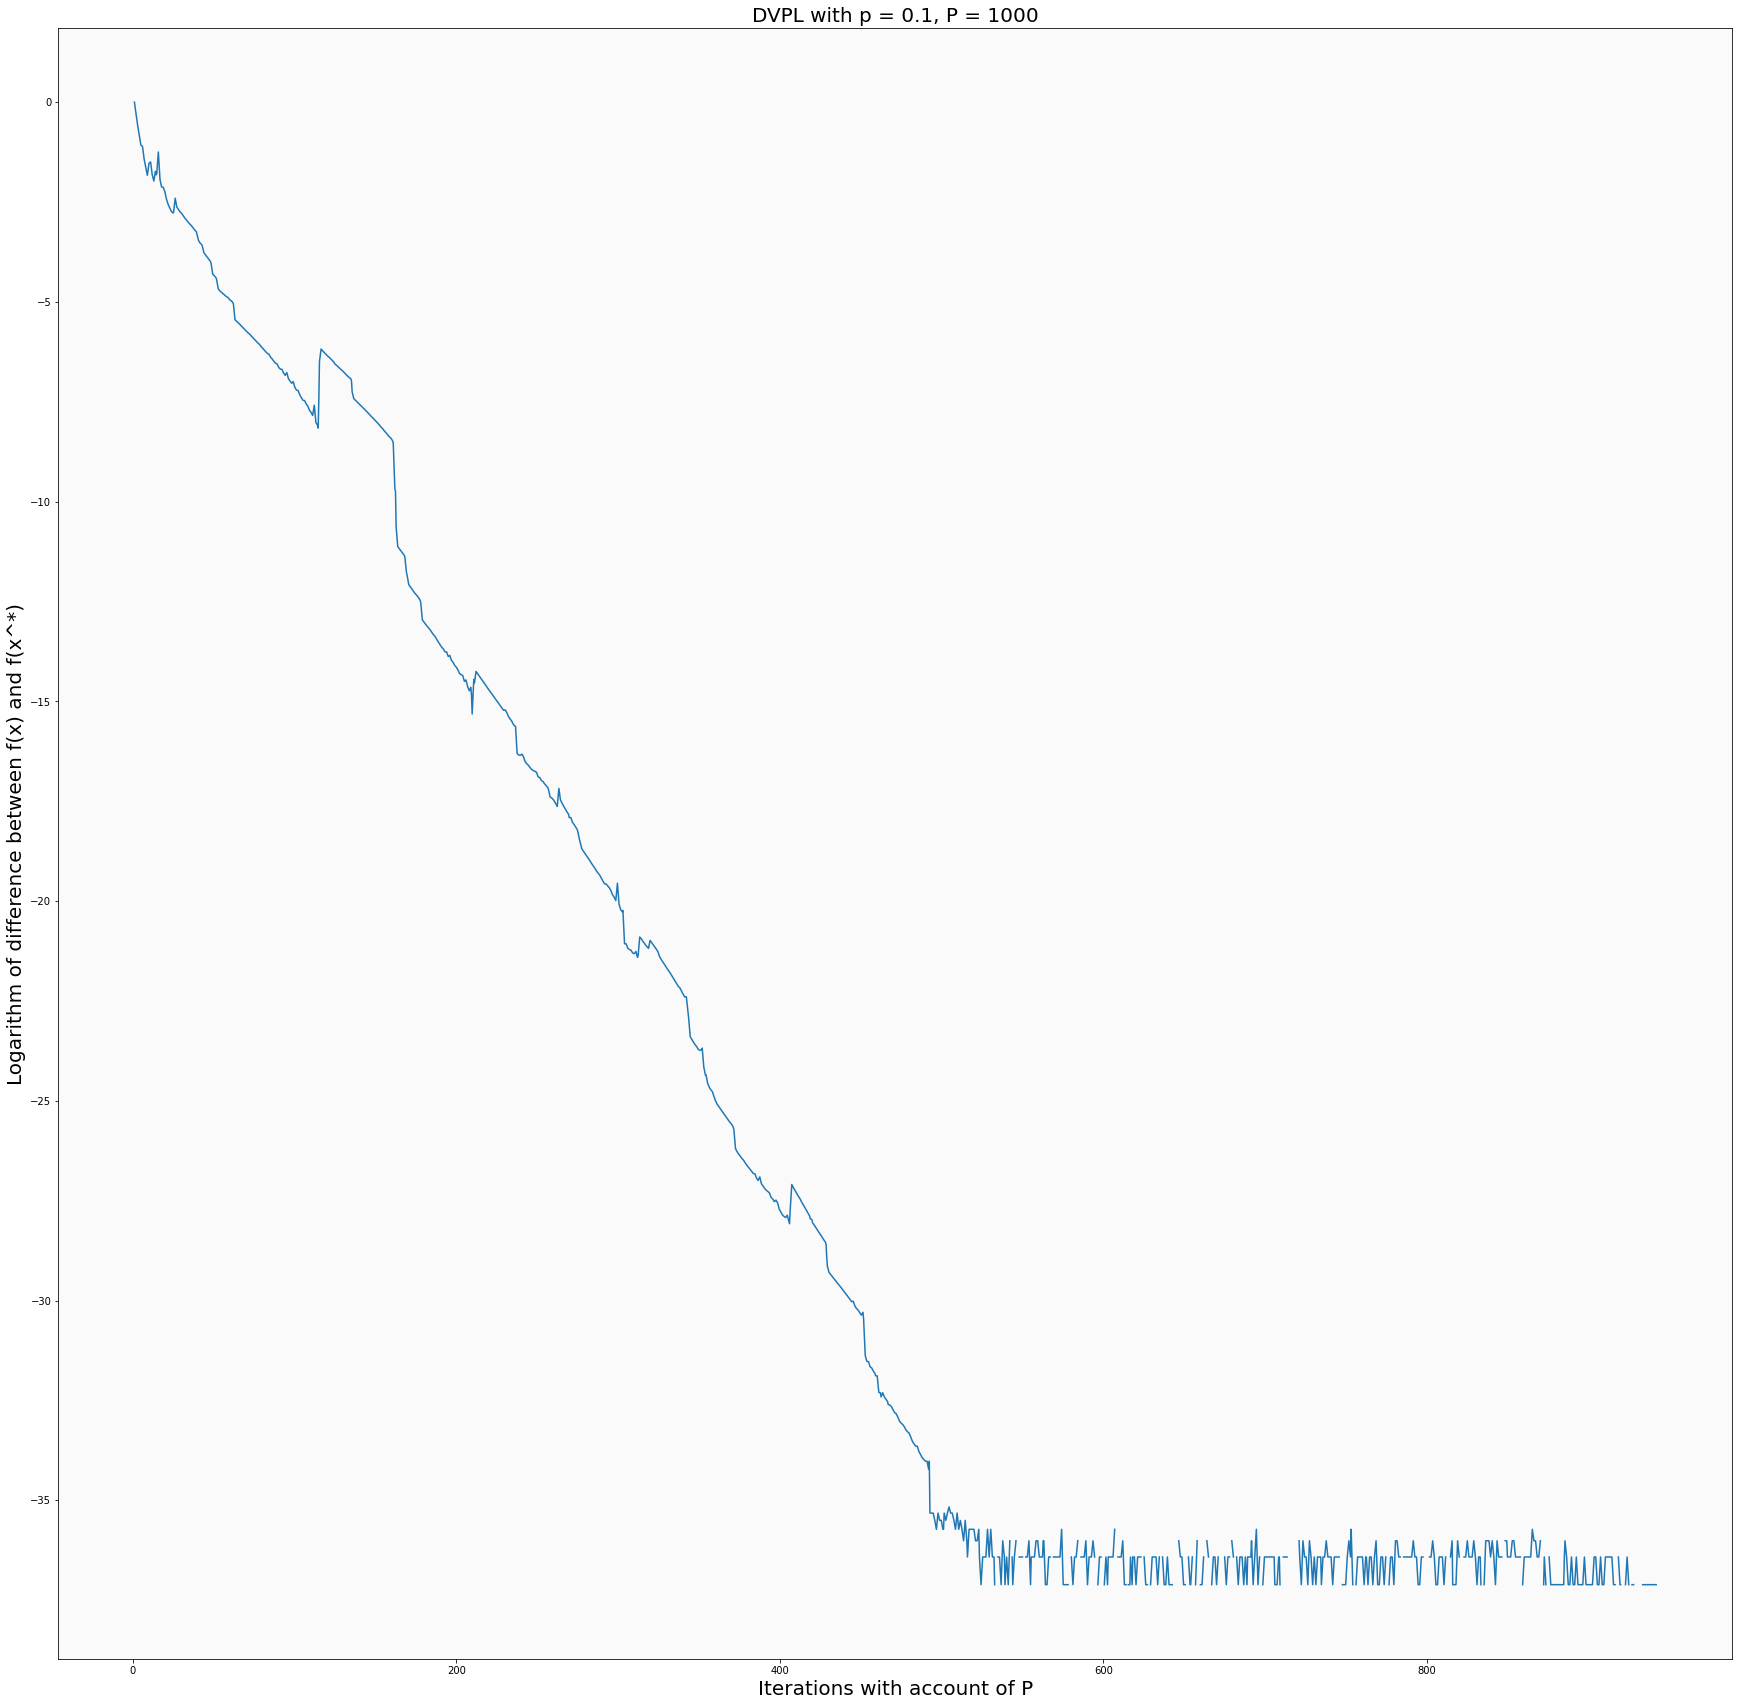

In [15]:
proc, x_axis = DVPL(X_train=X_train,
                    y_train=y_train,
                    max_iter=1000,
                    devices_num=device_num,
                    w_0=np.full(X_train.shape[1], 0, dtype=np.float64),
                    eta_x_sigma=eta_x_sigma,
                    eta_div_L_waved=eta_div_L_waved,
                    theta1=theta1,
                    f=f,
                    gradient=gradient,
                    batch_size=batch_size,
                    L=L,
                    mu=mu,
                    P=10,
                    p=0.1)

plt.plot(x_axis, np.log(proc))
plt.title("DVPL with p = 0.1, P = 1000", fontsize=20)
plt.xlabel("Iterations with account of P", fontsize=20)
plt.ylabel("Logarithm of difference between f(x) and f(x^*)", fontsize=20)
plt.gca().set_facecolor('#fafafa')
plt.show()

In [16]:
eta_x_sigma_s = np.array([1 / 1000000000, 1 / 100000, 1 / 100, 1, 100])
eta_div_L_waved_s = np.array([1 / 1000000000, 1 / 100000, 1 / 100, 1, 100])
theta1_s = np.array([1 / 1000000000, 1 / 100000, 1 / 1000, 1 / 50, 0.5])
P_s = np.array([10, 25, 100, 500, 1000])  #iterations of fastmix
p_s = np.array([0.0001, 0.001, 0.01, 0.1, 0.5])

Let's run DVPL on different parameters to see how they affect the convergence

/var/folders/_q/h4h3ghz564s22rz24b7hmy440000gn/T/ipykernel_2794/1608979128.py:20: RuntimeWarning: divide by zero encountered in log
  axs[i, j].plot(x_axis, np.log(proc),
/var/folders/_q/h4h3ghz564s22rz24b7hmy440000gn/T/ipykernel_2794/1608979128.py:20: RuntimeWarning: divide by zero encountered in log
  axs[i, j].plot(x_axis, np.log(proc),
/var/folders/_q/h4h3ghz564s22rz24b7hmy440000gn/T/ipykernel_2794/1608979128.py:20: RuntimeWarning: divide by zero encountered in log
  axs[i, j].plot(x_axis, np.log(proc),
/var/folders/_q/h4h3ghz564s22rz24b7hmy440000gn/T/ipykernel_2794/1608979128.py:20: RuntimeWarning: divide by zero encountered in log
  axs[i, j].plot(x_axis, np.log(proc),
/var/folders/_q/h4h3ghz564s22rz24b7hmy440000gn/T/ipykernel_2794/1608979128.py:20: RuntimeWarning: divide by zero encountered in log
  axs[i, j].plot(x_axis, np.log(proc),
/var/folders/_q/h4h3ghz564s22rz24b7hmy440000gn/T/ipykernel_2794/1608979128.py:20: RuntimeWarning: divide by zero encountered in log
  axs[i, j].p

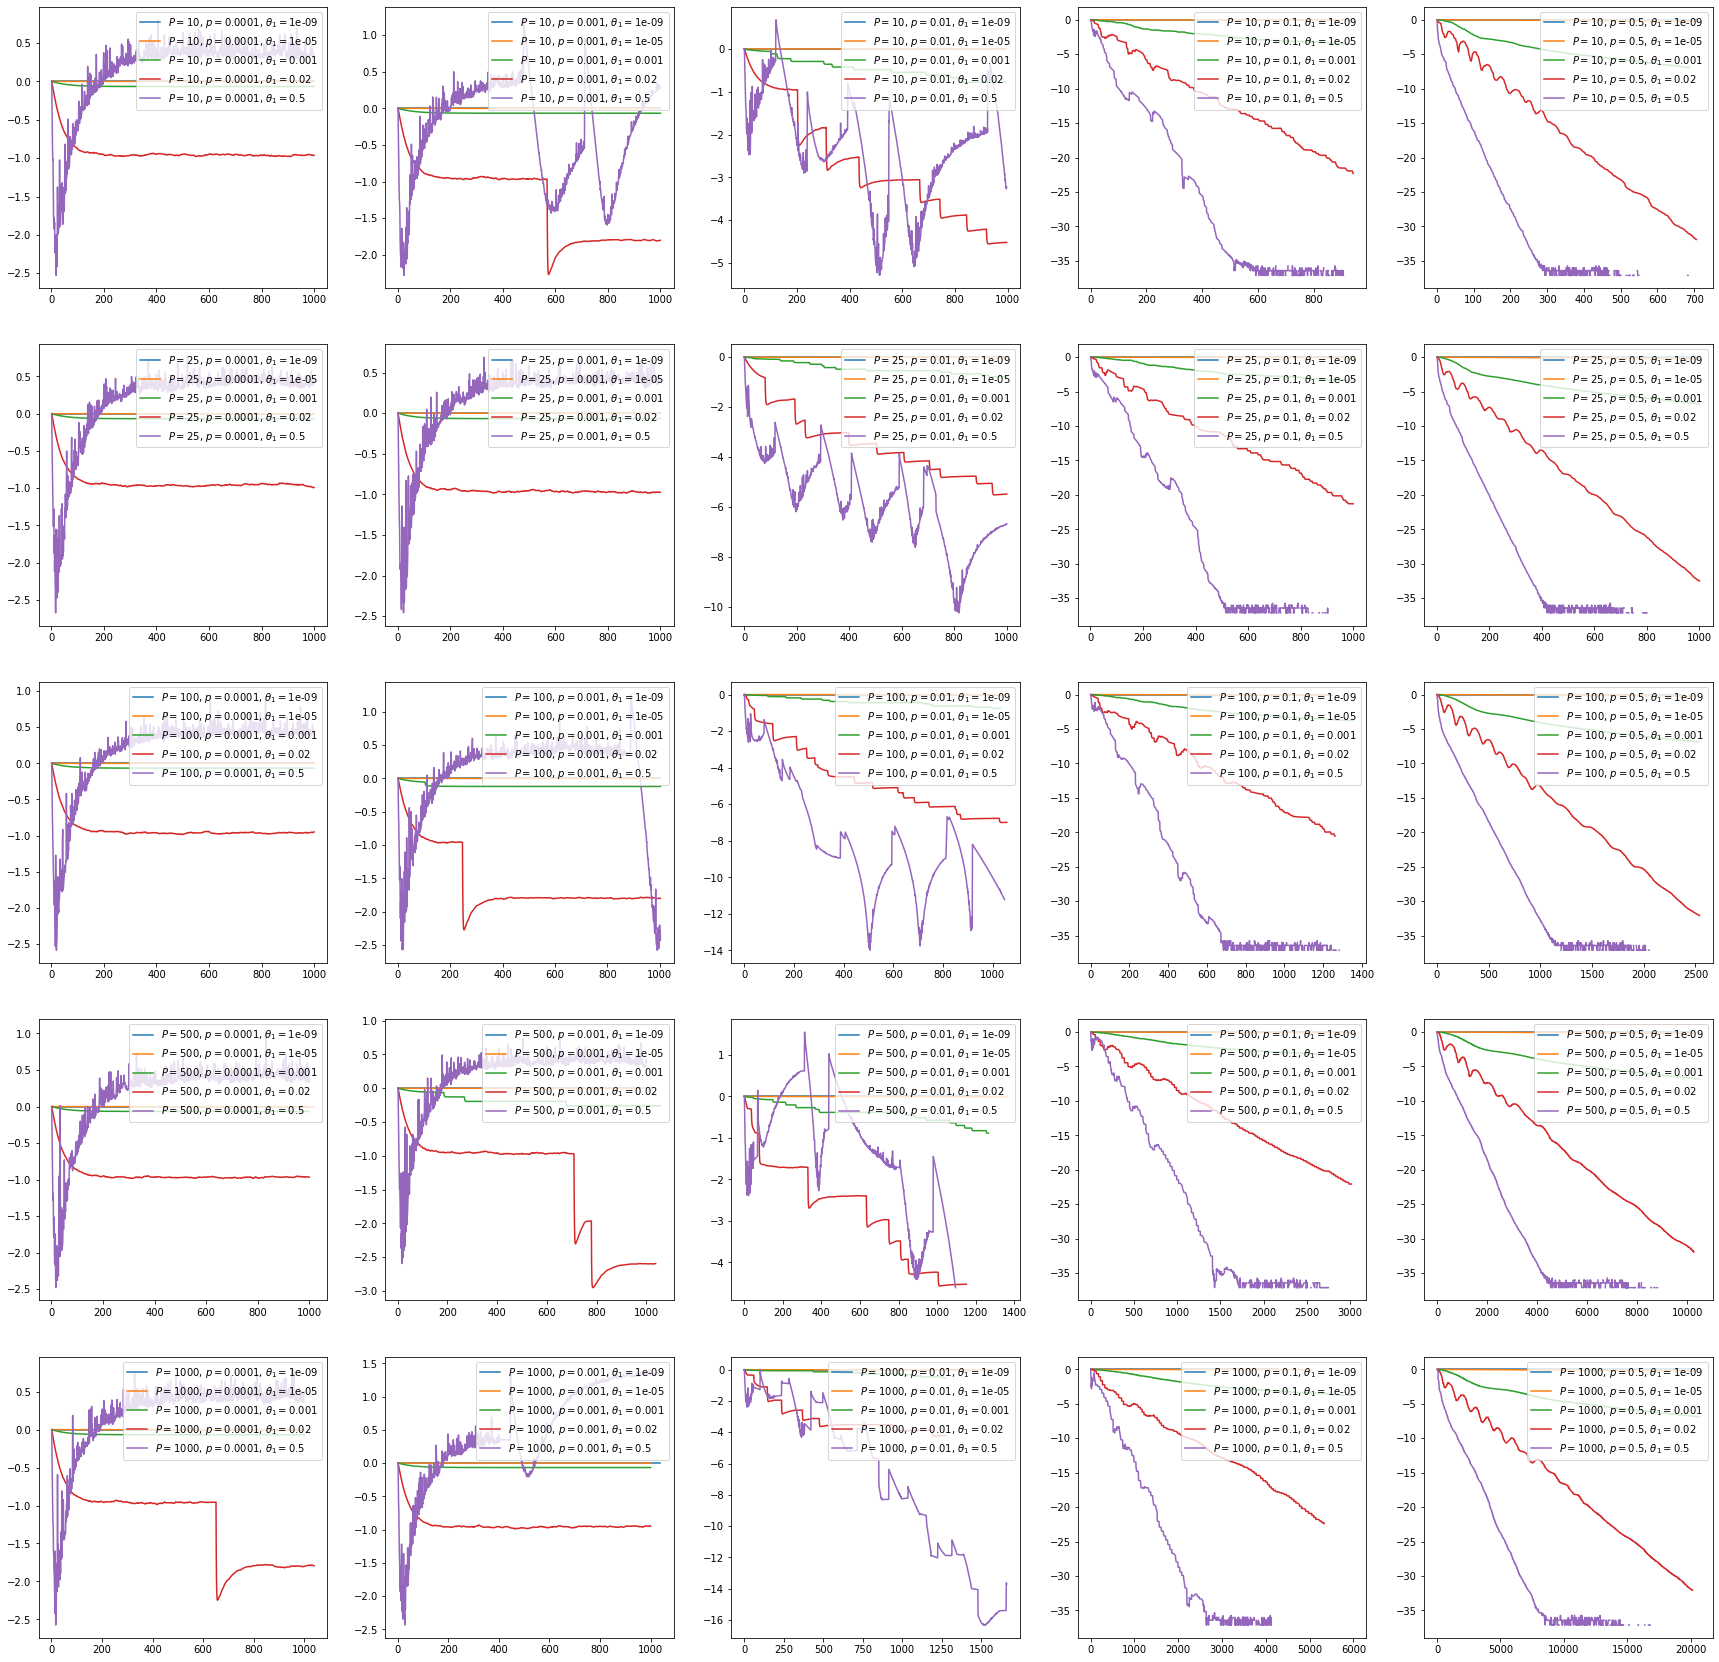

In [17]:
fig, axs = plt.subplots(P_s.size, p_s.size)
for i in range(P_s.size):
    for j in range(p_s.size):
        for k in range(theta1_s.size):
            proc, x_axis = DVPL(X_train=X_train,
                                y_train=y_train,
                                max_iter=1000,
                                devices_num=device_num,
                                w_0=np.full(X_train.shape[1], 0, dtype=np.float64),
                                eta_x_sigma=eta_x_sigma,
                                eta_div_L_waved=eta_div_L_waved,
                                theta1=theta1_s[k],
                                f=f,
                                gradient=gradient,
                                batch_size=batch_size,
                                L=L,
                                mu=mu,
                                P=P_s[i],
                                p=p_s[j])
            axs[i, j].plot(x_axis, np.log(proc),
                           label=R"$P=$" + str(P_s[i]) + R", $p=$" + str(p_s[j]) + R", $\theta_1=$" + str(theta1_s[k]))
        axs[i, j].legend(loc="upper right")